In [1]:
### If Google Colab
!git config --global user.email "sjs.shamsi@gmail.com"
!git config --global user.name "SJShamsi"

from google.colab import drive
drive.mount('/content/drive')

Thesis_Files = '/content/drive/MyDrive/Thesis_Files/'
filtered_lightcurves_file = Thesis_Files + "filtered_lightcurves.parquet"

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image as PILImage

plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['axes.grid'] = False

In [3]:
def numpy_to_pil(numpy_array):
    numpy_array = (numpy_array - numpy_array[:, :, :-1].min()) / (numpy_array[:, :, :-1].max() - numpy_array[:, :, :-1].min())
    numpy_array[:, :, 2] = np.zeros_like(numpy_array[:, :, 2])
    return Image.fromarray((numpy_array * 255).astype(np.uint8))

def density(numpy_array):
    numpy_array = (numpy_array - numpy_array[:, :, :-1].min()) / (numpy_array[:, :, :-1].max() - numpy_array[:, :, :-1].min())
    numpy_array[:, :, 2] = np.zeros_like(numpy_array[:, :, 2])
    return numpy_array

def norm1D(numpy_array):
    return numpy_array / numpy_array.sum()

### Save the Mahabal Bins
(but scaled to the $dm$ and $dt$ extrema fro our data)

In [4]:
all_lightcurves = pd.read_parquet(filtered_lightcurves_file)
all_lightcurves = all_lightcurves[all_lightcurves['type'].isin(['Q', 'QR', 'QX'])]

### Sampling to save disk space
fraction = 0.4
all_names = all_lightcurves['name'].unique()
sampled_names = np.random.choice(all_names, size=int(len(all_names) * fraction), replace=False)
all_lightcurves = all_lightcurves[all_lightcurves['name'].isin(sampled_names)]

In [5]:
dmints = np.array([-8,-5,-3,-2.5,-2,-1.5,-1,-0.5,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.5,1,1.5,2,2.5,3,5,8]) / 8
dtints = np.array([0.0,1.0/145,2.0/145,3.0/145,4.0/145,1.0/25,2.0/25,3.0/25,1.5,2.5,3.5,4.5,5.5,7,10,20,30,60,90,120,240,600,960,2000,4000]) * (1160 / 4000)

np.save(Thesis_Files + 'Thesis/dmdt_Analysis/Bins/dm_-1_1_Mahabal_bins_22.npy', dmints)
np.save(Thesis_Files + 'Thesis/dmdt_Analysis/Bins/dt_0_1160_Mahabal_bins_24.npy', dtints)

### We've already calculated the histograms for these Mahabal bins. Let's visualise them.

In [6]:
histogram_Mahabal_bins_df = pd.read_pickle(Thesis_Files + 'Thesis/dmdt_Analysis/Histograms/dmdt_histograms_21x23_Mahabal_bins.pkl')
histogram_Mahabal_bins_df.head()

,name,type,band,n_good_det,hist_p_scale,histogram
0,1E 22044+468,A,rg,"[697, 439]","[242556, 96141]","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,2E 1853.7+4452,A,rg,"[591, 158]","[174345, 12403]","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,2MASS J00265121-0159238,A,rg,"[257, 219]","[32896, 23871]","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,2MASS J00573811-1406173,A,rg,"[162, 147]","[13041, 10731]","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,2MASS J01283395-2358359,A,rg,"[81, 103]","[3240, 5253]","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


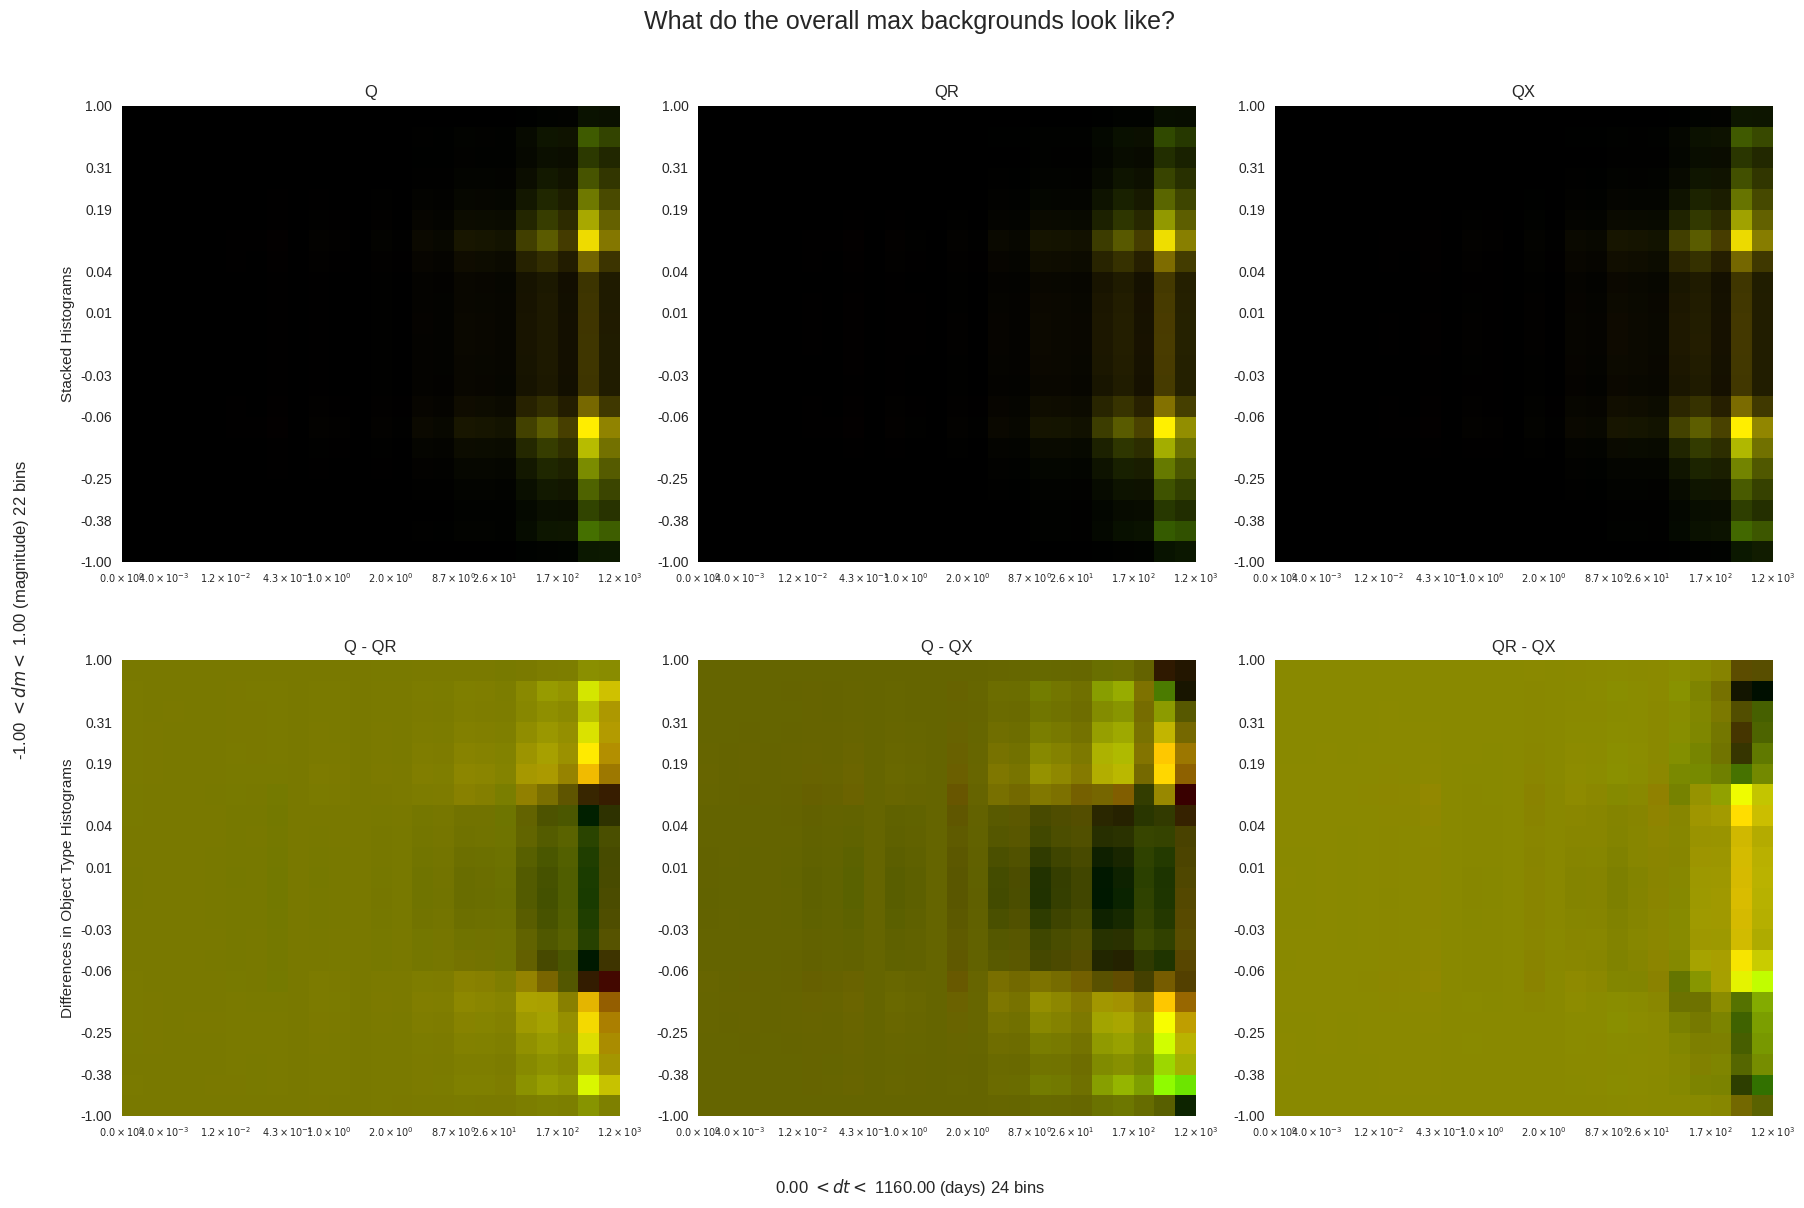

In [7]:
dm_bins, dt_bins = dmints, dtints
dm_nticks, dt_nticks = 10, 10

dm_indices = np.linspace(0, len(dmints) - 1, dm_nticks, dtype=int)
dt_indices = np.linspace(0, len(dtints) - 1, dt_nticks, dtype=int)

dm_ticks_labels = []
for index in dm_indices:
    formatted_string = f"{dmints[index]:.2f}"
    dm_ticks_labels.append(formatted_string)

dt_ticks_labels = []
for index in dt_indices:
    formatted_string = f"{dtints[index]:.1e}"
    base, exponent = formatted_string.split('e')
    dt_ticks_labels.append(f"${base} \\times 10^{{{int(exponent)}}}$")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

stacked_histograms = [histogram_Mahabal_bins_df.loc[histogram_Mahabal_bins_df['type'] == 'Q', 'histogram'].sum(),
                       histogram_Mahabal_bins_df.loc[histogram_Mahabal_bins_df['type'] == 'QR', 'histogram'].sum(),
                       histogram_Mahabal_bins_df.loc[histogram_Mahabal_bins_df['type'] == 'QX', 'histogram'].sum()]
stacked_histograms = [stacked_histograms[i] / stacked_histograms[i].sum() for i in range(len(stacked_histograms))]

difference_histograms = [stacked_histograms[0] - stacked_histograms[1],
                         stacked_histograms[0] - stacked_histograms[2],
                         stacked_histograms[1] - stacked_histograms[2]]

object_type_titles = ['Q', 'QR', 'QX']
difference_titles = ['Q - QR', 'Q - QX', 'QR - QX']

for ax, hist, title in zip(axs[0, :], stacked_histograms, object_type_titles):
    ax.imshow(numpy_to_pil(hist), extent=[0, len(dt_bins)-1, 0, len(dm_bins) - 1])
    ax.set_yticks(ticks=dm_indices, labels=dm_ticks_labels)
    ax.set_xticks(ticks=dt_indices, labels=dt_ticks_labels, size=7)
    ax.set_title(title)
axs[0, 0].set_ylabel('Stacked Histograms')

for ax, hist, title in zip(axs[1, :], difference_histograms, difference_titles):
    ax.imshow(numpy_to_pil(hist), extent=[0, len(dt_bins)-1, 0, len(dm_bins) - 1])
    ax.set_yticks(ticks=dm_indices, labels=dm_ticks_labels)
    ax.set_xticks(ticks=dt_indices, labels=dt_ticks_labels, size=7)
    ax.set_title(title)
axs[1, 0].set_ylabel('Differences in Object Type Histograms')

fig.supxlabel(f'{dt_bins.min():.2f} $< dt <$ {dt_bins.max():.2f} (days) {len(dt_bins) - 1} bins', size=12)
fig.supylabel(f'{dm_bins.min():.2f} $< dm <$ {dm_bins.max():.2f} (magnitude) {len(dm_bins) - 1} bins', size=12, x=0.0001)
fig.suptitle('What do the overall max backgrounds look like?', size=18, y=1)

plt.tight_layout()

In [8]:
distribution_save_path = Thesis_Files + 'Thesis/dmdt_Analysis/Bins/'

In [9]:
dm_min, dm_max = -1, 1
dt_min, dt_max = 1E-7, 2000

dm_nbins = 500
dt_nbins = 10_000

dm_bins = np.linspace(dm_min, dm_max, dm_nbins)
dt_bins = np.linspace(dt_min, dt_max, dt_nbins)

dm_bin_centres = [(dm_bins[i + 1] + dm_bins[i]) / 2 for i in range(len(dm_bins) - 1)]
dt_bin_centres = [(dt_bins[i + 1] + dt_bins[i]) / 2 for i in range(len(dt_bins) - 1)]

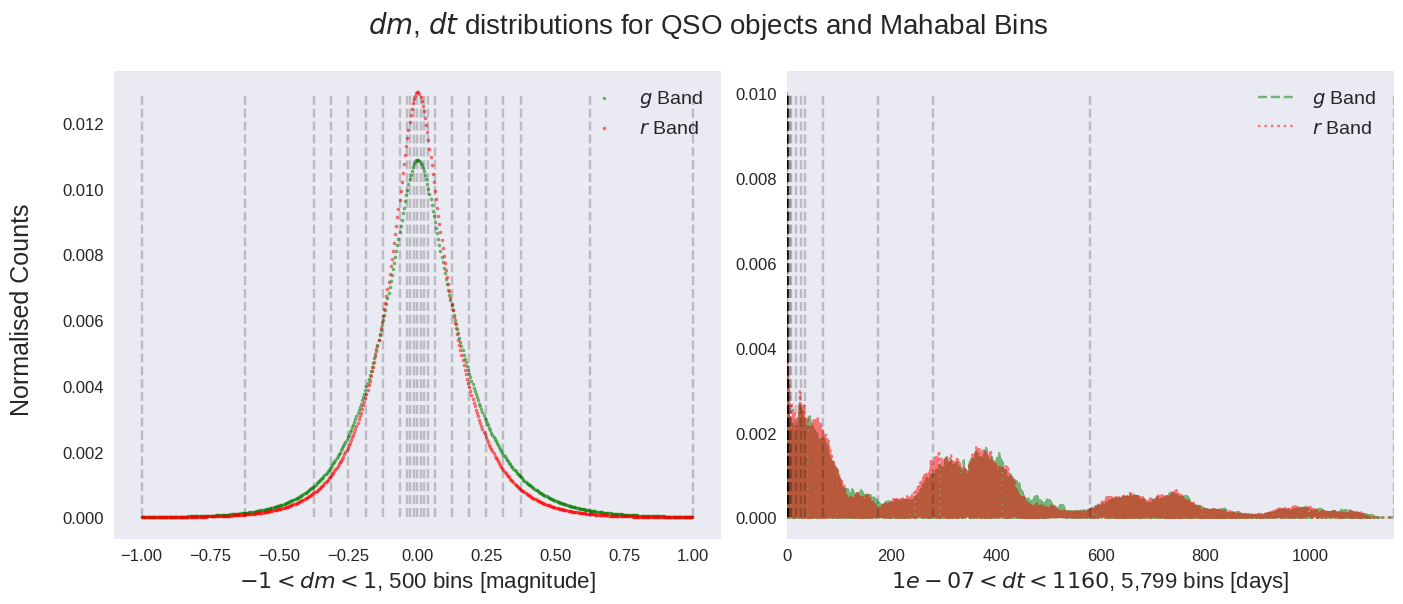

In [10]:
distribution_df = pd.read_pickle(distribution_save_path + f'QSO_distributions_dm_{dm_min}_{dm_max}_{dm_nbins}_dt_{dt_min}_{dt_max}_{dt_nbins}.pkl')

# dm distributions
dm_distribution_QSOs = distribution_df['dm_histogram'].sum()
g_dm_distribution_QSOs = distribution_df[distribution_df['band'] == 'g']['dm_histogram'].sum()
r_dm_distribution_QSOs = distribution_df[distribution_df['band'] == 'r']['dm_histogram'].sum()

# dt distributions
dt_distribution_QSOs = distribution_df['dt_histogram'].sum()
g_dt_distribution_QSOs = distribution_df[distribution_df['band'] == 'g']['dt_histogram'].sum()
r_dt_distribution_QSOs = distribution_df[distribution_df['band'] == 'r']['dt_histogram'].sum()


### Plots
n_bins = 51
dt_xmin = dt_min #days
dt_xmax = 1160 #days
alpha = 0.5
dt_bin_centres = np.array(dt_bin_centres)

### Plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axs[0].scatter(dm_bin_centres, norm1D(g_dm_distribution_QSOs), color='g', label='$g$ Band', alpha=alpha, s=5)
axs[0].scatter(dm_bin_centres, norm1D(r_dm_distribution_QSOs), color='r', label='$r$ Band', alpha=alpha, s=5)
axs[0].vlines(dmints, 0, norm1D(r_dm_distribution_QSOs).max(), linestyles='dashed', color='k', alpha=0.2)
axs[0].set_xlabel(f'${dm_min} < dm < {dm_max}$, {dm_nbins:,} bins [magnitude]', size=16)

axs[1].plot(dt_bin_centres, norm1D(g_dt_distribution_QSOs), color='g', label='$g$ Band', alpha=alpha, linestyle='--')
axs[1].plot(dt_bin_centres, norm1D(r_dt_distribution_QSOs), color='r', label='$r$ Band', alpha=alpha, linestyle=':')
axs[1].vlines(dtints, 0, norm1D(r_dt_distribution_QSOs).max(), linestyles='dashed', color='k', alpha=0.2)
axs[1].set_xlim(dt_xmin, dt_xmax)
axs[1].set_xlabel(f'${dt_xmin} < dt < {dt_xmax}$, {int(dt_nbins * ((dt_xmax - dt_xmin)/dt_max)):,} bins [days]', size=16)


for ax in axs.flatten():
    ax.legend(fontsize=14, facecolor='white', framealpha=1)
    ax.tick_params(axis='both', which='both', labelsize=12)

fig.suptitle('$dm$, $dt$ distributions for QSO objects and Mahabal Bins', size=20, y=1)
fig.supylabel('Normalised Counts', size=18, x=0.001)

plt.tight_layout()
plt.show()